In [8]:
# import sys
# !"{sys.executable}" -m pip install -q infomap

In [22]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
from infomap import Infomap

In [16]:
# 1. Load data
DATA_PATH = "data/soc-sign-bitcoinotc.csv"

col_names = ["source", "target", "rating", "time"]
df = pd.read_csv(DATA_PATH, names=col_names)

# Add datetime
df["datetime"] = pd.to_datetime(df["time"], unit="s")
df["year"] = df["datetime"].dt.year

print("Loaded:", df.shape, "edges")

# 2. Build full directed weighted (signed) graph
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_edge(
        int(row.source),
        int(row.target),
        rating=float(row.rating),
        time=int(row.time)
    )

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

# 3. Build positive-only directed graph

G_pos = nx.DiGraph()

for u, v, d in G.edges(data=True):
    if d["rating"] > 0:  # only trust edges
        G_pos.add_edge(u, v, **d)

print("Positive nodes:", G_pos.number_of_nodes())
print("Positive edges:", G_pos.number_of_edges())

# 4. Largest weakly connected component of positive graph

if G_pos.number_of_nodes() == 0:
    raise ValueError("No positive edges found.")

largest_pos_nodes = max(nx.weakly_connected_components(G_pos), key=len)
G_pos_lcc = G_pos.subgraph(largest_pos_nodes).copy()

print("Largest positive LCC nodes:", len(G_pos_lcc.nodes()))
print("Largest positive LCC edges:", len(G_pos_lcc.edges()))


Loaded: (35592, 6) edges
Nodes: 5881
Edges: 35592
Positive nodes: 5573
Positive edges: 32029
Largest positive LCC nodes: 5551
Largest positive LCC edges: 32007


## Build a directed, weighted positive-backbone for flow

Infomap can’t use negative weights (they don’t define flow), so we detect communities on positive ratings and later analyze where negatives fall (within vs between communities).

In [17]:
# Build directed, weighted positive-only graph
G_pos = nx.DiGraph()
for u, v, d in G.edges(data=True):
    r = float(d.get("rating", 0))
    if r > 0:
        # map rating 1..10 to weight (keep as-is or normalize)
        G_pos.add_edge(u, v, weight=r)

## Run Infomap (directed, weighted)

In [ ]:
# 1. Build positive-only graph (directed, weighted)
try:
    G_pos
except NameError:
    G_pos = nx.DiGraph()
    for u, v, d in G.edges(data=True):
        if d.get("rating", 0) > 0:
            G_pos.add_edge(int(u), int(v), weight=float(d["rating"]))

print("Positive graph:", G_pos.number_of_nodes(), "nodes,", G_pos.number_of_edges(), "edges")

# 2. Run Infomap
im = Infomap("--directed --two-level --silent --seed 42")

for u, v, data in G_pos.edges(data=True):
    im.add_link(int(u), int(v), float(data["weight"]))

im.run()

print("Infomap codelength:", im.codelength)

# 3. Extract modules
modules = {}   # node_id → community_id

for node in im.nodes:           # iterate over leaf nodes only
    modules[node.node_id] = node.module_id  

num_modules = len(set(modules.values()))
print("Detected modules:", num_modules)

# Preview
list(modules.items())[:10]


Positive graph: 5573 nodes, 32029 edges
Infomap codelength: 8.606868809156198
Detected modules: 352


[(905, 1),
 (1386, 1),
 (1334, 1),
 (1566, 1),
 (1396, 1),
 (304, 1),
 (1201, 1),
 (1317, 1),
 (1565, 1),
 (135, 1)]

Infomap finds 352 communities in the positive-only trust network, indicating extremely high fragmentation.
Users cluster into many small, tightly knit trust modules — essentially micro echo chambers.
The relatively low codelength (8.61 bits/step) shows that these community boundaries capture a strong underlying structure: trust flows primarily inside modules rather than across them.

## Compare to no communities (single-module) to show “savings”

In [20]:
# Get node visit probabilities from Infomap
p = [node.data.flow for node in im.nodes]

# Normalize
Z = sum(p)
p = [x / Z for x in p]

# Remove zeros (log(0) causes math domain error)
p_nonzero = [pi for pi in p if pi > 0]

# One-community baseline codelength
codelength_one = -sum(pi * math.log(pi, 2) for pi in p_nonzero)

# Infomap codelength
codelength_infomap = im.codelength

# Outputs
print(f"1-module baseline codelength: {codelength_one:.4f}")
print(f"Infomap codelength:           {codelength_infomap:.4f}")
print(f"Compression (absolute):       {codelength_one - codelength_infomap:.4f} bits/step")
print(f"Compression (relative):       {(1 - codelength_infomap / codelength_one) * 100:.2f}%")


1-module baseline codelength: 10.4378
Infomap codelength:           8.6069
Compression (absolute):       1.8310 bits/step
Compression (relative):       17.54%


- **10.4378 bits/step** - this is how many bits Infomap needs to describe the movements of a random walker if all nodes belonged to one community. This represents a network without community structure.

- **8.6069 bits/step** - this is the codelength after Infomap detects communities, using the real graph structure.
(Lower codelength ⇒ better compression ⇒ communities explain the flow well)

- **Absolute compression gain: 1.8310 bits/step** - this is how much shorter the description becomes when using communities instead of no communities.

- **Relative compression gain: 17.54% shorter** - Infomap compresses the description by 17.5% thanks to the communities.

#### Infomap reduces the codelength by 17.54% compared to a no-community baseline, confirming that the Bitcoin OTC trust network exhibits strong, non-random community structure driven by local trust clusters and echo-chamber dynamics.

## Use the Infomap partition to test echo chambers

In [21]:
# Map any node to its community (nodes missing from G_pos get -1)
comm_map = {n: modules.get(n, -1) for n in G.nodes()}

within = between = 0
for _, row in df.iterrows():
    if row["rating"] >= 0:
        continue  # only negatives
    cu = comm_map.get(row["source"], -1)
    cv = comm_map.get(row["target"], -1)
    if cu == -1 or cv == -1:
        continue
    if cu == cv:
        within += 1
    else:
        between += 1

tot = within + between
p_within  = within / tot if tot else 0.0
p_between = between / tot if tot else 0.0

print(f"Negative edges total: {tot} | within: {within} | between: {between}")
print(f"Proportions — within: {p_within:.3f}, between: {p_between:.3f}")


Negative edges total: 2788 | within: 98 | between: 2690
Proportions — within: 0.035, between: 0.965


96.5% of all negative interactions occur between communities.
Only 3.5% occur within communities.

This indicates strong echo chambers and inter-group distrust in the Bitcoin OTC network.

If between >> within, that’s strong evidence of echo chambers: trust clusters inside, distrust across.

## Year-by-year Infomap (directed)

In [26]:
# Precompute year column once
df["year"] = pd.to_datetime(df["time"], unit="s").dt.year
years = sorted(df["year"].unique())

results = []

for y in years:
    dyy = df[df["year"] == y]

    # Build directed positive graph for this year
    Gy = nx.DiGraph()
    for _, r in dyy.iterrows():
        if r["rating"] > 0:
            Gy.add_edge(int(r["source"]), int(r["target"]), weight=float(r["rating"]))

    if Gy.number_of_edges() == 0:
        continue  # no positive edges => skip this year

    # Run Infomap on this year's positive graph
    imy = Infomap("--directed --two-level --silent --seed 42")

    for u, v, data in Gy.edges(data=True):
        imy.add_link(int(u), int(v), float(data.get("weight", 1.0)))

    imy.run()

    # Correct way to extract partition for your Infomap version
    part_y = {node.id: node.module_id for node in imy.nodes}

    # Compute negatives within vs between communities for that year
    within = 0
    between = 0

    for _, r in dyy.iterrows():
        if r["rating"] >= 0:
            continue  # only negative edges
        cu = part_y.get(int(r["source"]), -1)
        cv = part_y.get(int(r["target"]), -1)
        if cu == -1 or cv == -1:
            continue  # node not in positive graph / not assigned
        if cu == cv:
            within += 1
        else:
            between += 1

    tot = within + between
    p_within = within / tot if tot else np.nan
    p_between = between / tot if tot else np.nan

    results.append({
        "year": int(y),
        "modules": len(set(part_y.values())),
        "codelength": imy.codelength,
        "neg_within_prop": p_within,
        "neg_between_prop": p_between
    })

# Show results by year
yearly_infomap = pd.DataFrame(results).sort_values("year")
display(yearly_infomap)


,year,modules,codelength,neg_within_prop,neg_between_prop
0,2010,1,4.432739,NaN,NaN
1,2011,1,7.365563,NaN,NaN
2,2012,1,7.414973,NaN,NaN
3,2013,1,7.550315,NaN,NaN
4,2014,1,6.315208,NaN,NaN
5,2015,1,5.408625,NaN,NaN
6,2016,1,1.684250,NaN,NaN


## Visualize Infomap communities on the network

This draws the positive largest component with nodes colored by Infomap community.
(For performance, you can sample nodes if it’s too dense.)

In [27]:
# !pip install scipy --quiet


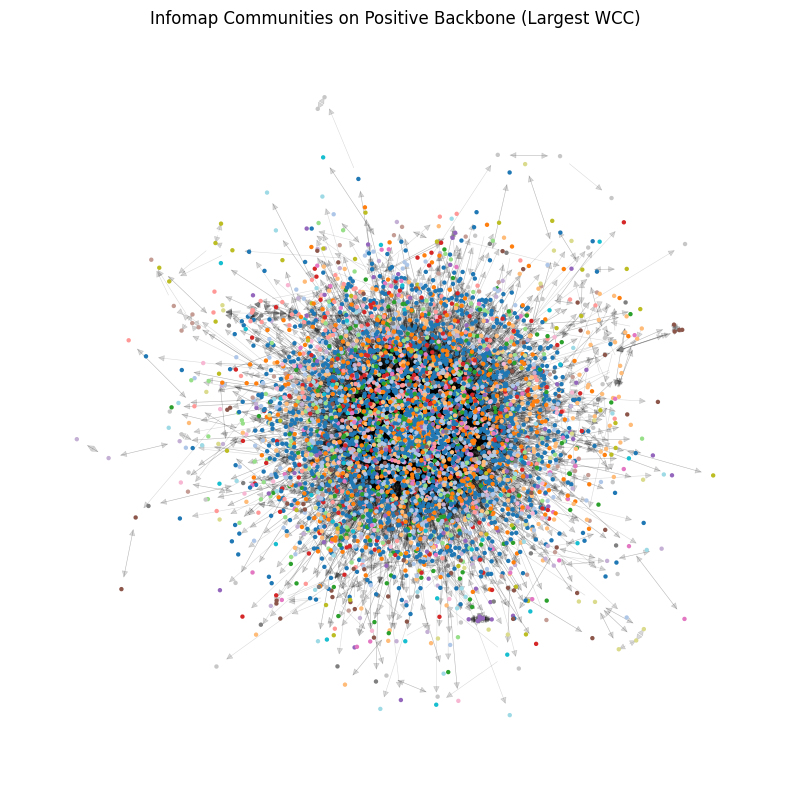

Saved to figures/infomap_positive_lcc_communities.png


In [25]:
H = G_pos_lcc 

# Community id for each node in H
comm_ids = [modules.get(int(n), -1) for n in H.nodes()]
unique_comms = sorted(set(comm_ids))

# Map each community to a value in [0,1] for coloring
if len(unique_comms) > 1:
    color_map = {
        c: i / (len(unique_comms) - 1)
        for i, c in enumerate(unique_comms)
    }
else:
    color_map = {c: 0.5 for c in unique_comms}

node_colors = [color_map[c] for c in comm_ids]

# Layout
pos = nx.spring_layout(H, k=0.15, iterations=50, seed=42)

plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    H, pos,
    node_color=node_colors,
    node_size=10,
    cmap=plt.cm.tab20,
    linewidths=0
)
nx.draw_networkx_edges(H, pos, alpha=0.15, width=0.4)
plt.title("Infomap Communities on Positive Backbone (Largest WCC)")
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/infomap_positive_lcc_communities.png", dpi=220, bbox_inches="tight")
plt.show()

print("Saved to figures/infomap_positive_lcc_communities.png")


Nodes are colored by Infomap communities on the directed positive backbone (largest weakly connected component). The plot shows visually separated trust clusters.

## Community meta-graph (median signed rating between Infomap communities)

Now we build a meta-network where:

- each node = one Infomap community
- each edge = median signed rating between two communities
- negative median edges highlight inter-community distrust

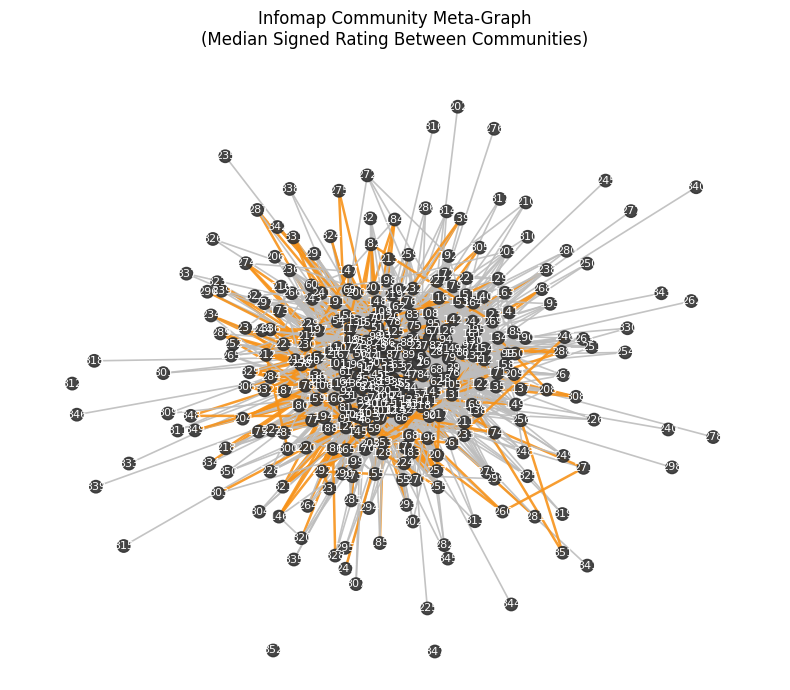

Saved to figures/infomap_community_meta_graph.png


In [ ]:

from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

BTC_ORANGE = "#f7931a"
DARK_GRAY  = "#333333"
LIGHT_GRAY = "#bdbdbd"

# Build pair → list of ratings for community pairs
pair_ratings = defaultdict(list)

for _, row in df.iterrows():
    u = int(row["source"])
    v = int(row["target"])
    r = float(row["rating"])
    cu = modules.get(u, None)
    cv = modules.get(v, None)
    if cu is None or cv is None:
        continue
    pair_ratings[(cu, cv)].append(r)

# Build meta-graph of communities
C = nx.Graph()

# Community sizes (how many nodes per module)
comm_sizes = {}
for node, c in modules.items():
    comm_sizes[c] = comm_sizes.get(c, 0) + 1

# Add community nodes
for c, sz in comm_sizes.items():
    C.add_node(c, size=int(sz))

def median_or_nan(values):
    if not values:
        return np.nan
    return float(np.median(values))

# Combine cu->cv and cv->cu interactions
seen = set()
for (c1, c2), vals_12 in pair_ratings.items():
    key = tuple(sorted((c1, c2)))
    if key in seen:
        continue
    seen.add(key)
    vals_21 = pair_ratings.get((c2, c1), [])
    vals = vals_12 + vals_21
    if not vals:
        continue
    med = median_or_nan(vals)
    if c1 == c2:
        # Within-community median rating (optional to use later)
        C.nodes[c1]["within_median"] = med
    else:
        C.add_edge(c1, c2, median=med, count=len(vals))

# Layout for meta-graph
pos = nx.spring_layout(C, seed=42, k=0.35)

plt.figure(figsize=(8, 7))

# Node sizes proportional to community size
node_sizes = [max(80, 0.5 * C.nodes[n]["size"]) for n in C.nodes()]

nx.draw_networkx_nodes(
    C, pos,
    node_size=node_sizes,
    node_color=DARK_GRAY,
    alpha=0.9
)

# Edge color & width by sign of median rating
edge_colors = []
edge_widths = []
for u, v, d in C.edges(data=True):
    med = d.get("median", 0.0)
    if med >= 0:
        edge_colors.append(LIGHT_GRAY)   # positive / neutral relation
        edge_widths.append(1.2)
    else:
        edge_colors.append(BTC_ORANGE)   # negative median (distrust)
        edge_widths.append(1.8)

nx.draw_networkx_edges(
    C, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.9
)
nx.draw_networkx_labels(C, pos, font_size=8, font_color="white")

plt.title("Infomap Community Meta-Graph\n(Median Signed Rating Between Communities)")
plt.axis("off")
plt.tight_layout()
plt.savefig("figures/infomap_community_meta_graph.png", dpi=220, bbox_inches="tight")
plt.show()

print("Saved to figures/infomap_community_meta_graph.png")


We construct a meta-graph where each node represents an Infomap community and edges represent the median signed rating between communities. Node size is proportional to community size. Edges with positive median ratings capture cooperative interactions, whereas edges with negative median ratings (highlighted in orange) indicate systematic distrust between communities. The presence of multiple negative inter-community edges, combined with mostly positive internal trust, supports the interpretation of the Bitcoin OTC market as a set of echo chambers: users trust members of their own community, but are more likely to express distrust towards users in other communities.